### Experimental Parameters

In [1]:
import numpy as np

proposal_rates = np.linspace(0.01, 1, 1)
n_trials = 1

### Setup JSON File

In [2]:
import json

# Create experimental parameters and write to JSON file

params = {'Block proposal rate parameter': 0,
 'Block size (txs)': 50,
 'Duration (sec)': 0,
 'Fork choice rule': 'GHOST',
 'Network model': 'Decker-Wattenhorf',
 'Number of adversaries': 1,
 'Number of nodes': 100,
 'Probability of error in transaction confirmation': 0.1,
 'Transaction dataset': 'poisson'}


### Run experiments

In [3]:
import os, shutil, pprint

pp = pprint.PrettyPrinter()
os.system('touch GHOST.json')
os.chdir('..')

import metrics

throughputs = {}
main_chain_arrival_latencies = {}
finalization_latencies = {}

for i in range(0, len(proposal_rates)):
    rate = proposal_rates[i]
    params['Block proposal rate parameter'] = rate
    params['Duration (sec)'] = 2400
    d = {}
    d['setting-name'] = f'GHOST-test'
    d[f'GHOST-test'] = params
    print('Parameters:')
    pp.pprint(d)
    with open('results/GHOST.json', 'w+') as outfile:
        json.dump(d, outfile)
    throughputs[rate] = []
    main_chain_arrival_latencies[rate] = []
    finalization_latencies[rate] = []
    for trial in range(0, n_trials):
        os.system('python3 main.py -f results/GHOST.json')
        throughput = metrics.compute_throughput()
        avg_main_chain_arrival_latency, avg_finalization_latency = metrics.compute_latency()
        throughputs[rate].append(throughput)
        main_chain_arrival_latencies[rate].append(avg_main_chain_arrival_latency)
        finalization_latencies[rate].append(avg_finalization_latency)


os.chdir('results/')
os.remove('GHOST.json')

print('Throughputs:\n', throughputs)
print('Main Chain Arrival Latencies:\n', main_chain_arrival_latencies)
print('Finalization Latencies:\n', finalization_latencies)

Parameters:
{'GHOST-test': {'Block proposal rate parameter': 0.01,
                'Block size (txs)': 50,
                'Duration (sec)': 2400,
                'Fork choice rule': 'GHOST',
                'Network model': 'Decker-Wattenhorf',
                'Number of adversaries': 1,
                'Number of nodes': 100,
                'Probability of error in transaction confirmation': 0.1,
                'Transaction dataset': 'poisson'},
 'setting-name': 'GHOST-test'}


ZeroDivisionError: division by zero

### Compute Averages

Average main chain latency is the time for a transaction to be added to the global blocktree - the timestamp the transaction was created.

Average finalization latency is the time for a transaction to be k blocks deep - to be added to the global blocktree.

In [4]:
avg_main_chain_latencies = {}
for rate in main_chain_arrival_latencies:
    avg_main_chain_latencies[rate] = sum(main_chain_arrival_latencies[rate])/len(main_chain_arrival_latencies[rate])

print("Average Main Chain Arrival Latency:", avg_main_chain_latencies)
avg_finalization_latencies = {}
for rate in finalization_latencies:
    avg_finalization_latencies[rate] = sum(finalization_latencies[rate])/len(finalization_latencies[rate])
    
print("Average Finalization Latency:", avg_finalization_latencies)


Average Main Chain Arrival Latency: {0.01: 122.39714098201989}
Average Finalization Latency: {0.01: 413.3678797223281}


### Extract Finalization Depth and Delta for Blocks

In [5]:
import csv
with open('../logs/stats.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        if row[0]=='Finalization depth':
            k = int(row[1])
        elif row[0]=='Average network latency for blocks (sec)':
            delta = float(row[1])

### Plotting the results

In [6]:
import matplotlib.pylab as plt
x = avg_main_chain_latencies.keys()
y1 = avg_main_chain_latencies.values()
expected_y1 = (1.0/delta+1.0/proposal_rates)
y2 = avg_finalization_latencies.values()
expected_y2 = k*(delta+1.0/proposal_rates)

plt.xlabel('Block Proposal Rate (blocks/sec)')
plt.ylabel('Main Chain Arrival Latency (sec)')
plt.title(f'Main Chain Arrival Latency vs. Proposal Rate (k={k}, delta={delta})')
plt.grid(True)

plt.plot(x, y1, label='observed rate')
plt.plot(x, expected_y1, '--', label='expected rate')
plt.legend()
plt.show()

<Figure size 640x480 with 1 Axes>

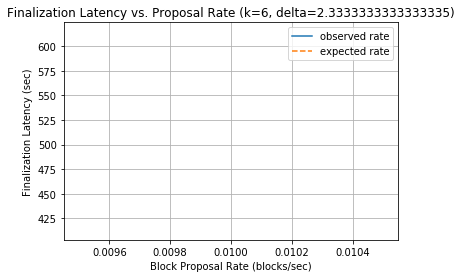

In [7]:
plt.xlabel('Block Proposal Rate (blocks/sec)')
plt.ylabel('Finalization Latency (sec)')
plt.title(f'Finalization Latency vs. Proposal Rate (k={k}, delta={delta})')
plt.grid(True)

plt.plot(x, y2, label='observed rate')
plt.plot(x, expected_y2, '--', label='expected rate')
plt.legend()
plt.show()